## Exercise 2d)

In this notebook, we explore the testing MSE of our neural network as a function of the model architecture and learning rate. The goal is to find the set of values of the hyperparameters that give the smallest value of the testing MSE. Thus, we create figure 4 in the report. 

In [ ]:
LOAD_FROM_FILE = True  # load data from file, so the bottlenecks of the program run in just a few seconds

In [ ]:
# Autoreload
%load_ext autoreload
%autoreload 1
%aimport utils.neural_network, utils.training, utils.step_methods, utils.cost_functions, utils.activation_functions, utils.utils

# Imports
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import TrainingMethod, StochasticGradientDescent, GradientDescent
from utils.step_methods import StepMethod, RMSpropStep, AdamStep
from utils.cost_functions import MSE
from utils.activation_functions import Sigmoid, Identity, ReLU, LeakyReLU
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from utils.utils import generate_dataset, runge, plot_mse_data, analyze_model_learning_rates, r2, skip_if
import pickle
from copy import deepcopy

plt.style.use('./utils/_plot_style.mplstyle')

In [ ]:
# Generate dataset
np.random.seed(124)

n = 300
x, y = generate_dataset(num=n)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=44)

# Scale dataset
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_mean = y_train.mean()

In [ ]:
# Define models

nodes = list(range(10,86,15))
hidden_layers = [1,3,5]

activation_funcs = [
    ("Sigmoid", Sigmoid()),
    ("ReLU", ReLU()), 
    ("LeakyReLU",LeakyReLU())
]

training_methods = ("SGD", StochasticGradientDescent, (-4, 1))
step_methods = ("ADAM", AdamStep(0, 0.9, 0.999))

n_learning_rates = 8
iterations = 3000
all_mse_data = np.zeros((len(nodes), len(hidden_layers), len(activation_funcs),n_learning_rates))

_,training_method, (min_log_lr,max_log_lr) = training_methods
learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))

In [ ]:
%%skip_if LOAD_FROM_FILE

# Analyze mse vs. learning rate and number of nodes for different numbers of hidden layers and activation functions. 
for i, n_nodes in enumerate(nodes):
    print("\nNode: ",n_nodes, end="")
    for j, n_hidden_layers in enumerate(hidden_layers):
        for k, (name,activation_func) in enumerate(activation_funcs):

            model = NeuralNetwork(    # define neural network
                    network_input_size = 1,
                    layer_output_sizes = [n_nodes]*n_hidden_layers  + [1],
                    activation_funcs = [activation_func]*n_hidden_layers + [Identity()],
                    cost_fun = MSE(), 
                    layers_random_state = 23
                    )

            np.random.seed(124)
            mse_data = analyze_model_learning_rates(
                model,
                training_method(     # train neural network and return testing MSE
                    step_method = step_methods[1],
                    inputs = x_train_scaled,
                    targets = y_train - y_mean,
                    test_inputs = x_test_scaled,
                    test_targets = y_test - y_mean,
                ),
                learning_rates, 
                iterations,
            )
            print(".",end="")
            all_mse_data[i][j][k] = mse_data

In [ ]:
filepath = "../data/mse_vs_lr_nodes_final.npy"

# Save data to file
# np.save(filepath, all_mse_data)

# Load data from file
if LOAD_FROM_FILE:
    all_mse_data = np.load(filepath)

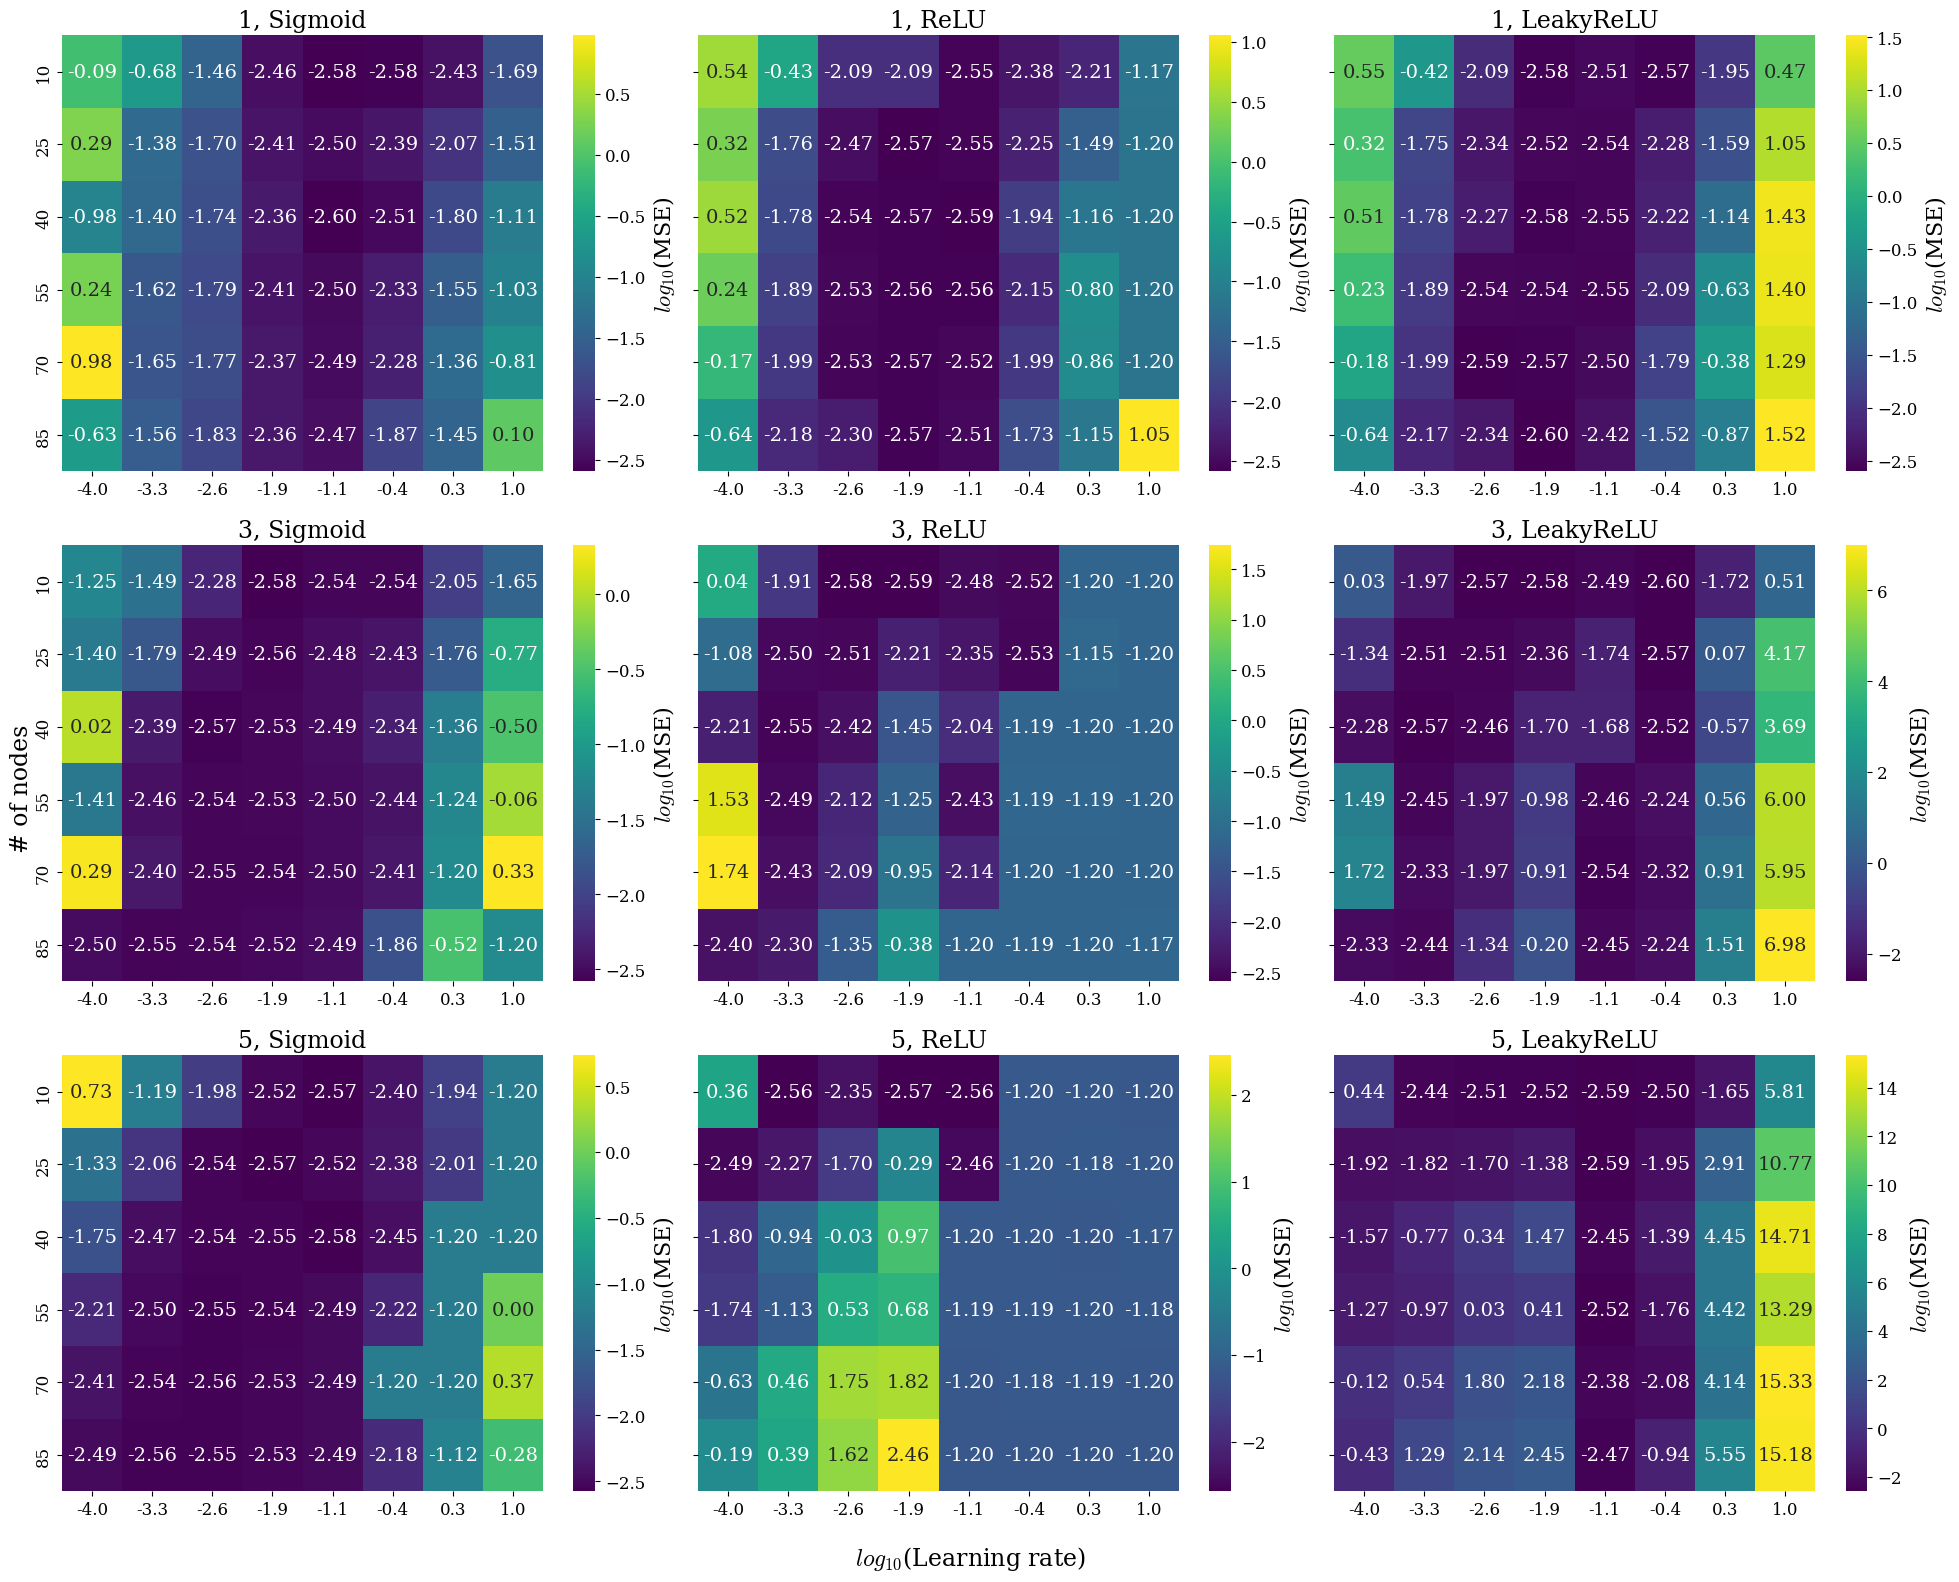

In [ ]:
# Plot MSE vs. learning rate and model architecture

import seaborn as sns

fig, axes = plt.subplots(len(hidden_layers), len(activation_funcs), figsize=(20, 16), sharey=True)
for j,n_hidden_layers in enumerate(hidden_layers):
    for k, (name,activation_func) in enumerate(activation_funcs):
        mse_data = all_mse_data[:,j,k,:]
        sns.heatmap(
            np.log10(np.array(mse_data)),  
            ax = axes[j,k],
            fmt=".2f",   
            annot=True,
            cmap="viridis", 
            xticklabels=np.round(np.log10(np.array(learning_rates)),1),
            yticklabels=nodes,cbar_kws={"label": r"$log_{10}$(MSE)"}
            )
        axes[j,k].set_title(fr"{n_hidden_layers}, {name}",fontsize=17)

    fig.supxlabel(r"$log_{10}$(Learning rate)",fontsize=17)
    fig.supylabel("# of nodes",fontsize=17)
plt.savefig("../figs/mse_vs_lr_nodes_final.pdf")
plt.show()

Finally, once we found the optimal model architecture and learning rate, we calculate the corresponding R^2 score of the neural network and of OLS regression. 

In [ ]:
%%skip_if LOAD_FROM_FILE

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=44)
scaler = StandardScaler()
nn_mse = np.zeros(n_splits)
ols_mse = np.zeros(n_splits)

# OLS model
ols_model = make_pipeline(
    PolynomialFeatures(degree=12, include_bias=False),
    StandardScaler(),
    LinearRegression(fit_intercept=False)
)

nn_model = NeuralNetwork(
    1,
    [40,1],
    [Sigmoid(), Identity()],
    MSE(),
)

for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scale data
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    y_mean = y_train.mean()

    # Train and evaluate Neural Network
    nn_model.reset_layers(random_state=123) # Reset neural network layers
    mse_data = nn_model.train(
        StochasticGradientDescent(
            step_method = AdamStep(learning_rate=learning_rates[4]),
            inputs = x_train_scaled,
            targets = y_train - y_mean,
            test_inputs = x_test_scaled,
            test_targets = y_test - y_mean
        ),
        num_iterations = 3000,
        track_mse = True
    )
    y_pred_nn = nn_model.predict(x_test_scaled) + y_mean
    nn_mse[fold_idx] = MSE()(y_pred_nn, y_test)

    # Train and evaluate OLS model
    ols_model.fit(x_train, y_train - y_mean) # This model already includes a scaler
    y_pred_ols = ols_model.predict(x_test) + y_mean
    ols_mse[fold_idx] = MSE()(y_pred_ols, y_test)


In [ ]:
filepath = "../data/mse_vs_lr_nodes_final.npz"

# Save data to file
# np.savez(filepath, array1 = nn_mse, array2 = ols_mse)

# Load data from file
if LOAD_FROM_FILE:
    nn_mse = np.load(filepath)["array1"]
    ols_mse = np.load(filepath)["array2"]

In [ ]:
# Printing final R^2 scores of neural network and OLS regression. 

print("Neural network R^2 score for cross validation with optimal hyperparameters: ",r2(np.mean(nn_mse),y))
print("OLS regression R^2 score for cross validation: ",r2(np.mean(ols_mse),y))

Neural network R^2 score for cross validation with optimal hyperparameters:  0.9642165606893718
OLS regression R^2 score for cross validation:  0.9601015499712551
